In [83]:
# Data Handling
import numpy as np
import pandas as pd

# Vizz
import matplotlib.pyplot as plt
import missingno as msno
from matplotlib.cm import ScalarMappable
import seaborn as sns

# Transformations
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from scipy.spatial.distance import cdist
from sklearn.metrics import mean_absolute_error

# Reading Data

In [2]:
data_path = '../data/' # ./data or ../data

In [3]:
part_1 = pd.read_csv(data_path+'data_part_1.csv', index_col=False); part_1 = part_1[part_1.columns[1:]] # Getting rid of idx col
part_2 = pd.read_csv(data_path+'data_part_2.csv', index_col=False); part_2 = part_2[part_2.columns[1:]] # Getting rid of idx col

# Joining datasets

In [4]:
data_df=pd.concat([part_1, part_2], axis=0,join="inner")

# Create a dataset without missing values for each trait + List of those data

In [5]:
# We have 20 target variables and so, we split the data into 20 different dataframes for each target variable. 
# After that, we drop the rows with missing values in the target variable and then, we drop the target variable from the dataframes.
# We are left with 20 dataframes with no missing values in the target variable.
# Now, we create a list of target variables and a list of input variables.
input_cols = data_df.columns[20:]
target_cols = data_df.columns[:20]
y=[]
x=[]
for i in range(20):
    y.append(data_df.iloc[:,i].dropna(axis=0))
    x_temp=data_df.iloc[y[i].index,20:]
    x.append(x_temp)

## Train, Validation, and Test split of the list of the data

In [6]:
# We now split the list of input variables and target variables into train, test and validation sets.
# So, we will have a list of 20 train sets, 20 test sets and 20 validation sets.
train_xl = []
train_yl = []
test_xl = []
test_yl = []
val_xl = []
val_yl = []
for X_matrix, y_target in zip(x, y):
    X_train, X_temp, y_train, y_temp = train_test_split(X_matrix, y_target, test_size=0.3, random_state=42,shuffle=True)
    X_validation, X_test, y_validation, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    train_xl.append((X_train))
    train_yl.append((y_train))
    test_xl.append((X_test))
    test_yl.append((y_test))
    val_xl.append((X_validation))
    val_yl.append((y_validation))

## Normalization of the train, validation, and test data list

In [7]:
X_train_scaled=[]
X_test_scaled=[]
X_val_scaled=[]

for i in range(20):
# Z-score (STD) normalization
    scaler = StandardScaler()
    X_train_scaled_temp = scaler.fit_transform(train_xl[i])
    X_test_scaled_temp = scaler.transform(test_xl[i])
    X_val_scaled_temp = scaler.transform(val_xl[i])
    X_train_scaled.append(X_train_scaled_temp)
    X_test_scaled.append(X_test_scaled_temp)
    X_val_scaled.append(X_val_scaled_temp)

# MLR

In [61]:
predictions_MLR = []

mse_train_list = []
mse_val_list = []
r2_train_list = []
r2_val_list = []

# Loop through each target column
for trait in range(len(target_cols)):
    X_train = X_train_scaled[trait]
    y_train = train_yl[trait]
    X_test = X_test_scaled[trait]
    y_test = test_yl[trait]
    
    # Train the MLR model
    mlr = LinearRegression()
    mlr.fit(X_train, y_train)

    # Make predictions using the model
    y_train_pred = mlr.predict(X_train)
    y_val_pred = mlr.predict(X_test) 
    
    predictions_MLR.append(y_val_pred)

    # Calculate performance metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_val = mean_squared_error(y_test, y_val_pred) 
    r2_train = r2_score(y_train, y_train_pred)
    r2_val = r2_score(y_test, y_val_pred) 

    mse_train_list.append(mse_train)
    mse_val_list.append(mse_val)
    r2_train_list.append(r2_train)
    r2_val_list.append(r2_val)

# Print out the performance metrics for each target
for i, target in enumerate(target_cols):
    print(f"Target: {target}")
    print(f"Train MSE: {mse_train_list[i]:.4f} | Validation MSE: {mse_val_list[i]:.4f}")
    print(f"Train R^2: {r2_train_list[i]:.4f} | Validation R^2: {r2_val_list[i]:.4f}")
    print("-" * 50)

Target: Anthocyanin content (μg/cm²)
Train MSE: 0.0144 | Validation MSE: 19.7874
Train R^2: 0.9216 | Validation R^2: -114.5111
--------------------------------------------------
Target: Boron content (mg/cm²)
Train MSE: 0.0000 | Validation MSE: 459053.9127
Train R^2: 0.9906 | Validation R^2: -6373745488848.2969
--------------------------------------------------
Target: C content (mg/cm²)
Train MSE: 0.3081 | Validation MSE: 4472894421.2815
Train R^2: 0.9873 | Validation R^2: -205550560.0248
--------------------------------------------------
Target: Ca content (mg/cm²)
Train MSE: 0.0001 | Validation MSE: 891451989.8444
Train R^2: 0.9915 | Validation R^2: -61370025525.8204
--------------------------------------------------
Target: Carotenoid content (μg/cm²)
Train MSE: 0.2670 | Validation MSE: 24953122287.2876
Train R^2: 0.9680 | Validation R^2: -2686169438.7494
--------------------------------------------------
Target: Cellulose (mg/cm²)
Train MSE: 0.0276 | Validation MSE: 2905965418129.

# PCR

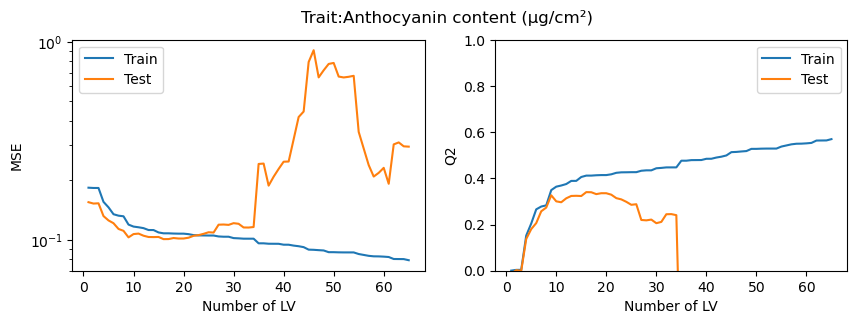

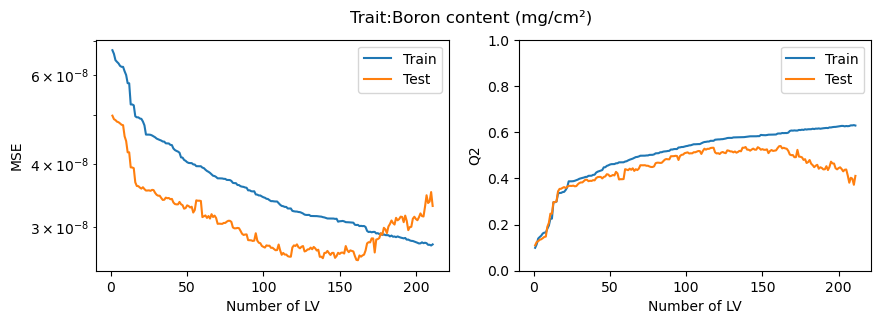

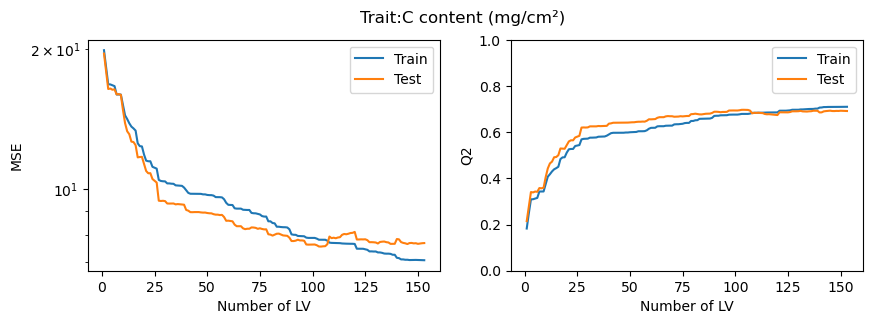

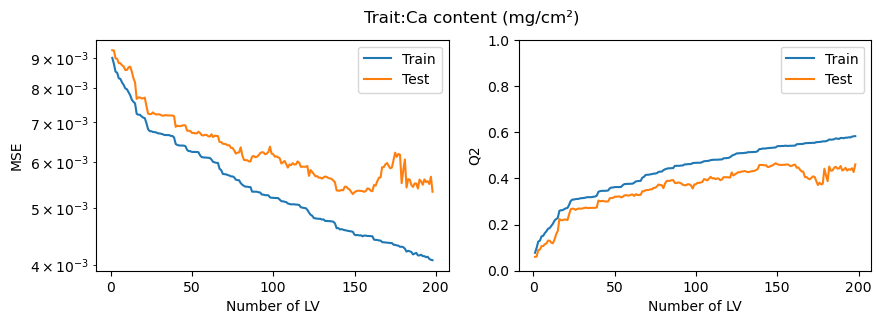

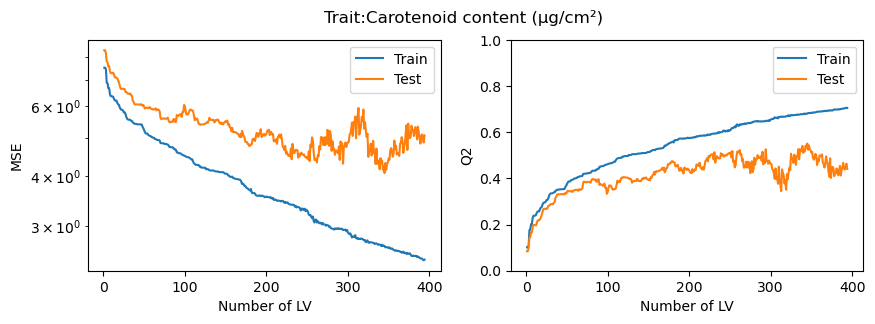

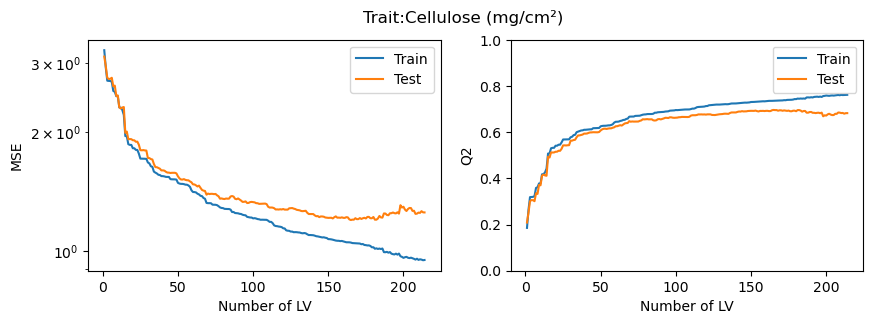

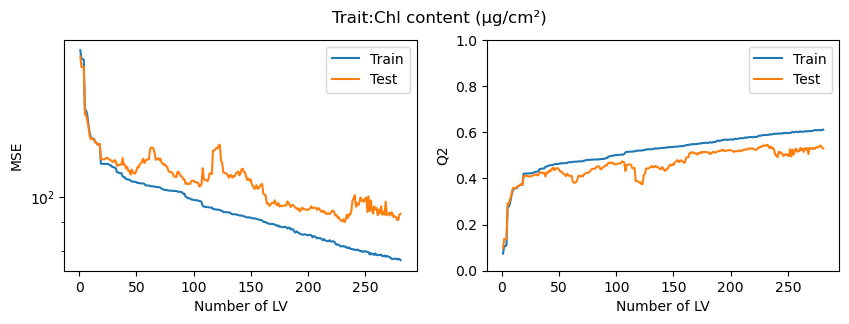

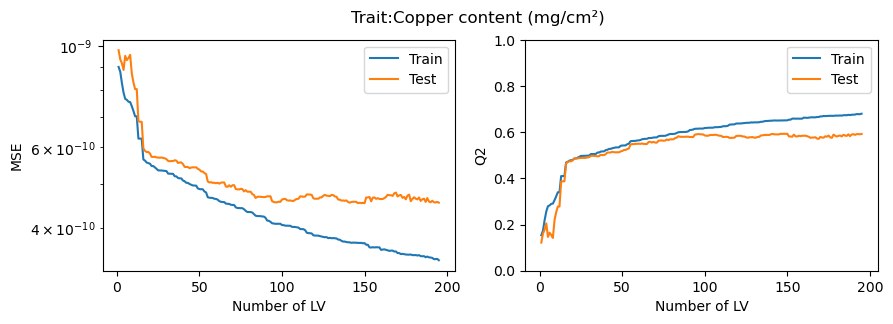

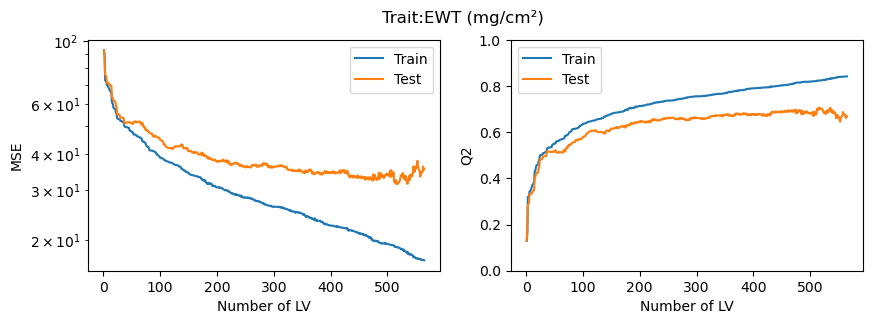

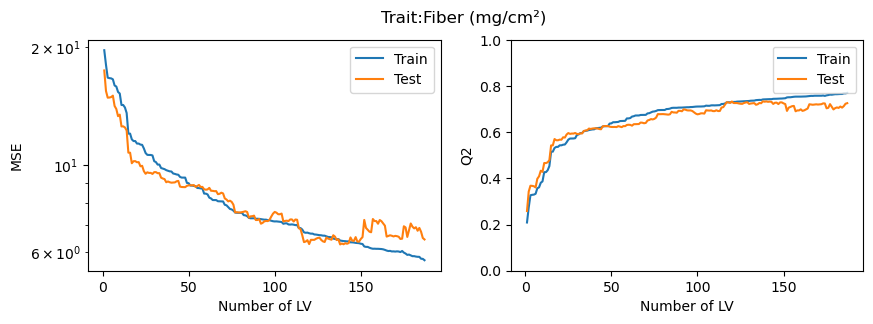

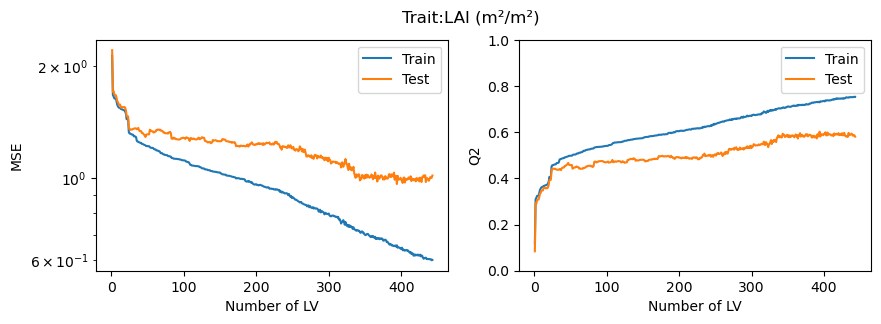

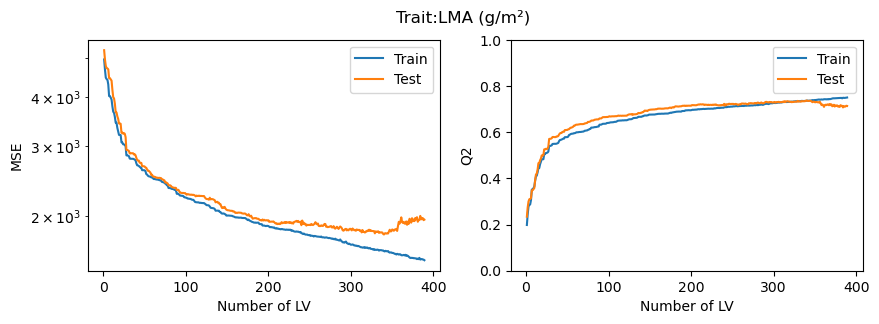

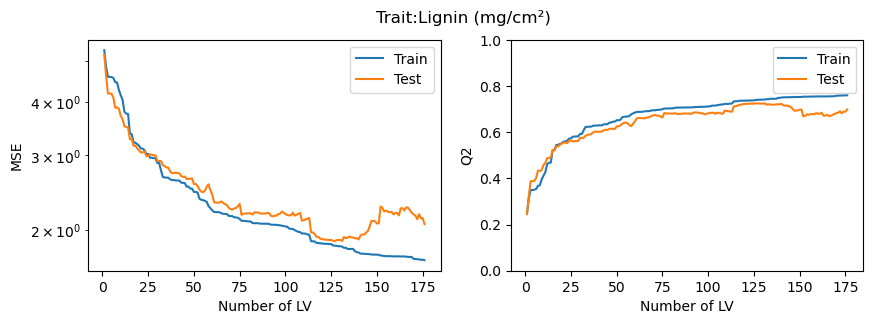

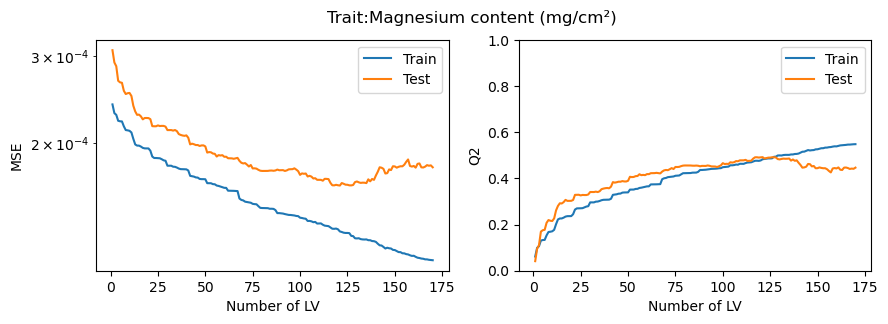

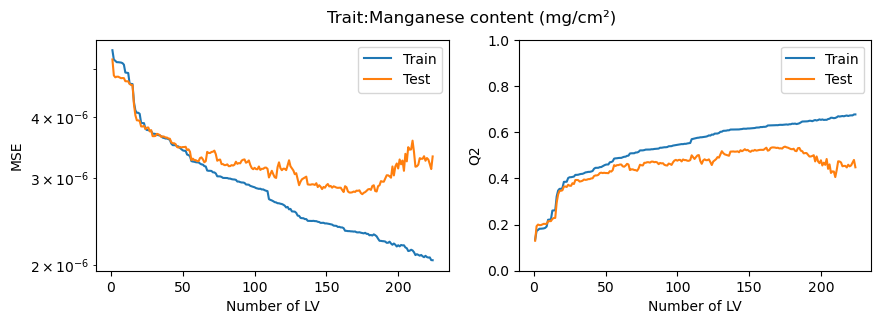

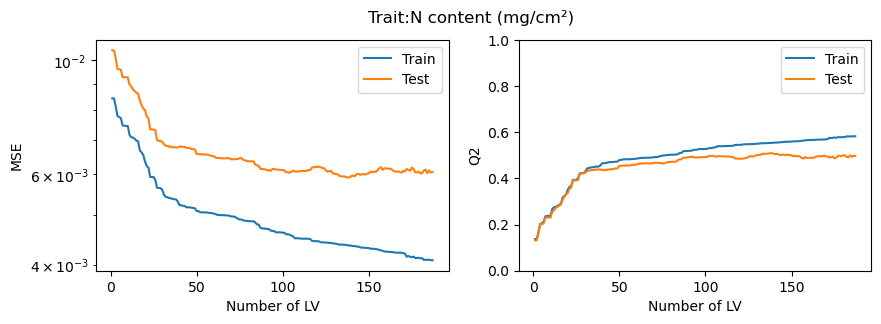

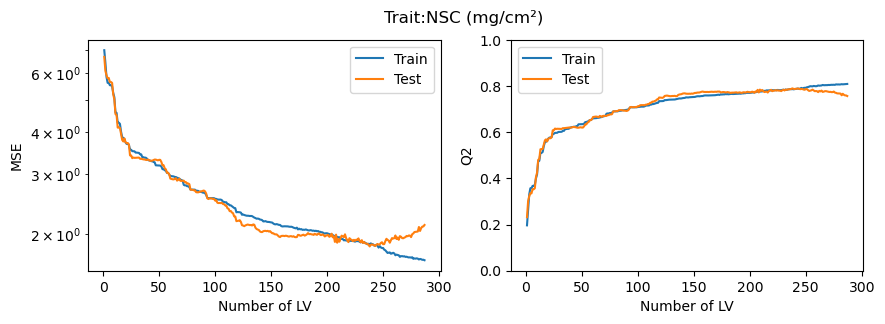

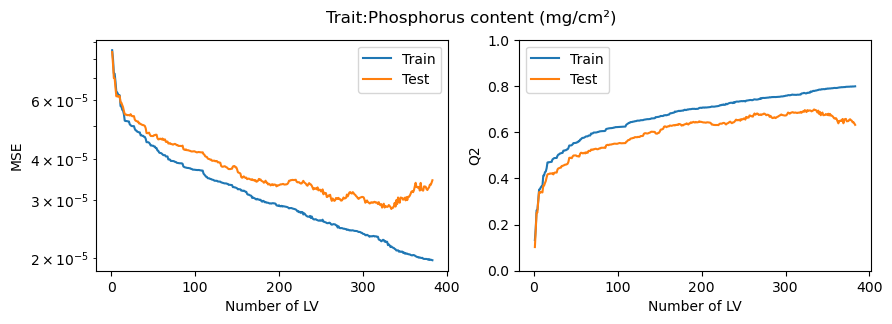

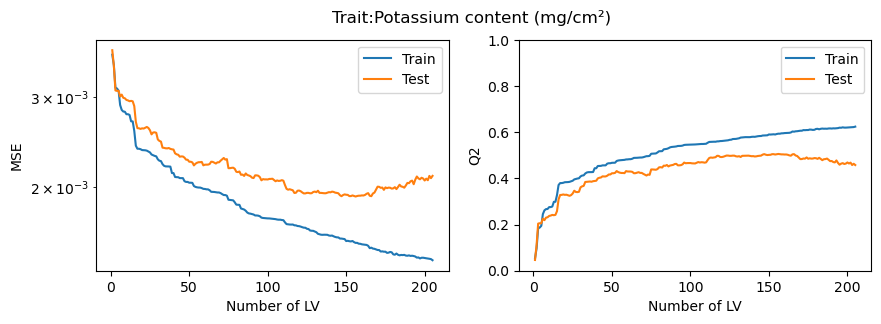

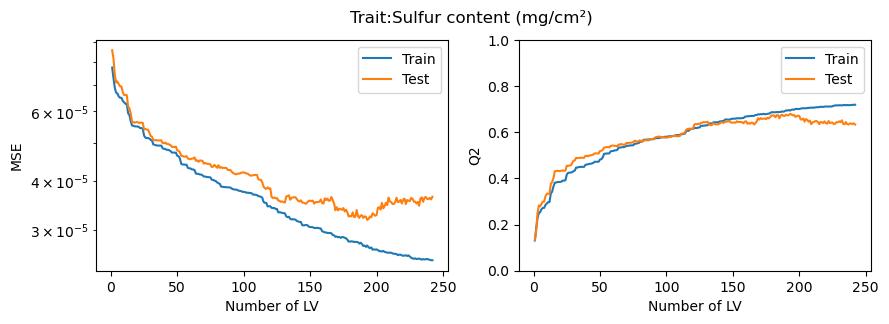

In [55]:
# For PCR

# We will be using a maximum of 100 latent variables as we have seen that with only two we already
# reach a high percentage
optimal_components = np.zeros(len(target_cols))


for trait in range(len(target_cols)): # For a single trait
    X_train = X_train_scaled[trait]
    y_train = train_yl[trait]
    X_test = X_val_scaled[trait]
    y_test = val_yl[trait]
    
    train_mse = []
    test_mse = []
    train_q2 = []
    test_q2 = []
    LV_vals = np.arange(1, min(X_train.shape[0], X_train.shape[1])) 

    for comp in LV_vals: # For a single Latent variable
        pca = PCA(n_components = comp)
        T = pd.DataFrame(pca.fit_transform(X_train))
        reg = LinearRegression().fit(T, y_train)

        y_est_pcr_train = reg.predict(T)
        y_est_pcr_test = reg.predict(pca.transform(X_test))

        train_mse.append(mean_squared_error(y_train, y_est_pcr_train))
        test_mse.append(mean_squared_error(y_test, y_est_pcr_test))

        train_q2.append(r2_score(y_train, y_est_pcr_train))
        test_q2.append(r2_score(y_test, y_est_pcr_test))
        
        if comp > 50: # Implementing early stopping of 50
            for mse in test_mse[comp-49:]:
                if test_mse[comp-50] > mse:
                    break
            else:
                LV_vals = np.arange(1, comp+1)
                optimal_components[trait] = comp-50
                break

    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].plot(LV_vals, train_mse, label = 'Train')
    ax[0].plot(LV_vals, test_mse, label = 'Test')
    ax[0].set_xlabel("Number of LV")
    ax[0].set_ylabel("MSE")
    ax[0].set_yscale('log')
    ax[0].legend()

    ax[1].plot(LV_vals, train_q2, label = 'Train')
    ax[1].plot(LV_vals, test_q2, label = 'Test')
    ax[1].set_xlabel("Number of LV")
    ax[1].set_ylabel("Q2")
    ax[1].set_ylim(0, 1)
    ax[1].legend()
    plt.suptitle("Trait:"+target_cols[trait])
    plt.show()

In [77]:
# Predicting on X_Test
predictions_PCR = []

for trait, comp in zip(range(len(target_cols)), optimal_components): # For a single trait
    X_train = X_train_scaled[trait]
    y_train = train_yl[trait]
    X_test = X_test_scaled[trait]
    y_test = test_yl[trait]
    
    pca = PCA(n_components = int(comp))
    T = pd.DataFrame(pca.fit_transform(X_train))
    reg = LinearRegression().fit(T, y_train)

    predictions_PCR.append(reg.predict(pca.transform(X_test)))

# PLS

Text(0, 0.5, 'R2 score')

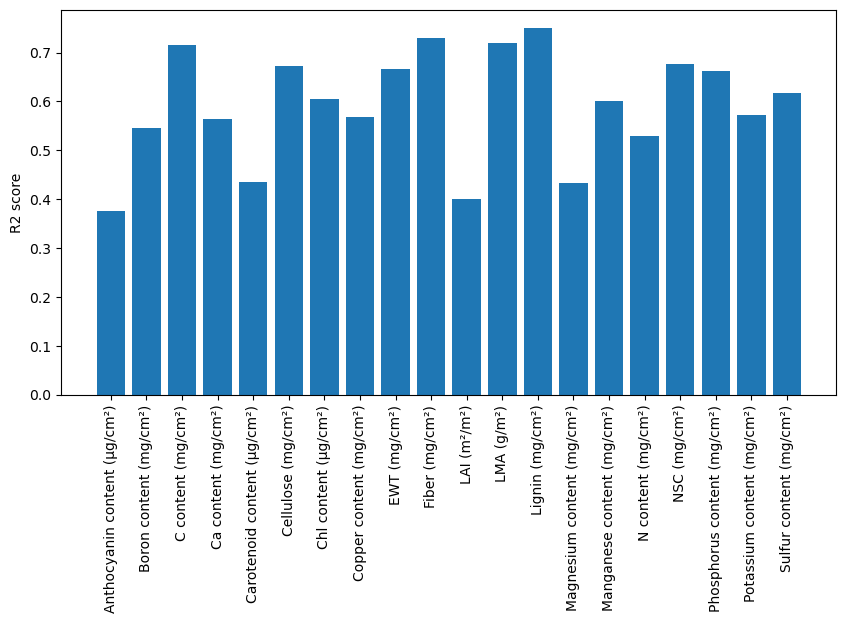

In [80]:
pls_component_list=[10,61,67,108,97,60,85,44,88,50,20,100,80,55,63,45,41,59,72,76] # Found using grid search
r2_PLS=[]
cross_val_r2_values = []
ypred_PLS=[]
n_components_range = range(1, 30) 
for i in range(20):
    
    pls = PLSRegression(n_components=pls_component_list[i])
    pls.fit(X_train_scaled[i],train_yl[i])

    y_pred = pls.predict(X_test_scaled[i])
    ypred_PLS.append(y_pred)
    
    r2_test = r2_score(test_yl[i], y_pred)
    r2_PLS.append(r2_test)

plt.figure(figsize=(10,5))
plt.bar(np.arange(len(r2_PLS)), r2_PLS)
plt.xticks(np.arange(len(r2_PLS)), target_cols, rotation=90)
plt.ylabel("R2 score")

In [86]:
predictions_PLS = ypred_PLS

# KPLS

C:\Users\Pau\anaconda3\envs\BSC_Practiques\lib\site-packages\sklearn\cross_decomposition\_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss
C:\Users\Pau\anaconda3\envs\BSC_Practiques\lib\site-packages\sklearn\cross_decomposition\_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss
C:\Users\Pau\anaconda3\envs\BSC_Practiques\lib\site-packages\sklearn\cross_decomposition\_pls.py:319: RuntimeWarning: divide by zero encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss
C:\Users\Pau\anaconda3\envs\BSC_Practiques\lib\site-packages\sklearn\cross_decomposition\_pls.py:319: RuntimeWarning: invalid value encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss
C:\Users\Pau\anaconda3\envs\BSC_Practiques\lib\site-packages\sklearn\cross_decomposition\_pls.py:319: RuntimeWarning: divide by zero encountered in divide
  y_scores = np.dot(Yk, y_weights) / y_ss
C:\Users\Pau\anaco

Text(0, 0.5, 'R2 score')

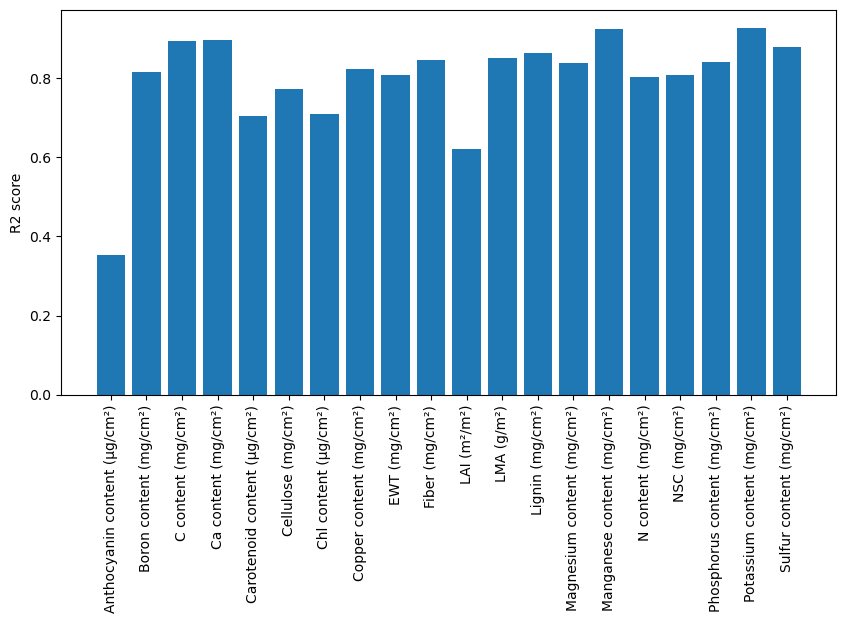

In [82]:
pls_component_list=[10,61,67,108,97,60,85,44,88,50,20,100,80,55,63,45,41,59,72,76]
sigma = 0.5
ypred_KPLS=[]
r2_KPLS=[]
for i in range(len(target_cols)):
# Calculate the Gaussian kernel matrices for calibration and test data
    KCal = np.exp(-cdist(X_train_scaled[i], X_train_scaled[i], 'euclidean')**2 / (2 * sigma**2))
    KTest = np.exp(-cdist(X_test_scaled[i], X_train_scaled[i], 'euclidean')**2 / (2 * sigma**2))


    # Center the calibration kernel matrix
    nl = KCal.shape[0]
    oneN = np.ones((nl, nl)) / nl
    KCal = KCal - oneN @ KCal - KCal @ oneN + oneN @ KCal @ oneN

    n = KCal.shape[0]
    oneN = np.ones((n, n)) / n
    nTest = KTest.shape[0]
    oneNTest = np.ones((nTest, n)) / n
    KTest = KTest - oneNTest @ KCal - KTest @ oneN + oneNTest @ KCal @ oneN

    # Perform K-PLS regression using the calibration data
    pls = PLSRegression(n_components=pls_component_list[i])
    pls.fit(KCal, train_yl[i])

    Ypred = pls.predict(KTest)
    ypred_KPLS.append(Ypred)
    r2_test = r2_score(test_yl[i], Ypred)
    r2_KPLS.append(r2_test)

plt.figure(figsize=(10,5))
plt.bar(np.arange(len(r2_KPLS)), r2_KPLS)
plt.xticks(np.arange(len(r2_KPLS)), target_cols, rotation=90)
plt.ylabel("R2 score")

In [85]:
predictions_KPLS = ypred_KPLS

# Comparing the models

In [87]:
# Compare the predictions with different metrics
mse_arr = []
r2_arr = []
mae_arr = []

# predictions_PCR, predictions_KPLS, predictions_MLR, predictions_PLS

for trait in range(len(target_cols)):
    r2_MLR = r2_score(test_yl[trait], predictions_MLR[trait])
    r2_PCR = r2_score(test_yl[trait], predictions_PCR[trait])
    r2_PLS = r2_score(test_yl[trait], predictions_PLS[trait])
    r2_KPLS = r2_score(test_yl[trait], predictions_KPLS[trait])
    
    r2_arr.append([r2_MLR, r2_PCR, r2_PLS, r2_KPLS])
   
    
    mse_MLR = mean_squared_error(test_yl[trait], predictions_MLR[trait])
    mse_PCR = mean_squared_error(test_yl[trait], predictions_PCR[trait])
    mse_PLS = mean_squared_error(test_yl[trait], predictions_PLS[trait])
    mse_KPLS = mean_squared_error(test_yl[trait], predictions_KPLS[trait])
    
    mse_arr.append([mse_MLR, mse_PCR, mse_PLS, mse_KPLS])
    
    
    mae_MLR = mean_absolute_error(test_yl[trait], predictions_MLR[trait])
    mae_PCR = mean_absolute_error(test_yl[trait], predictions_PCR[trait])
    mae_PLS = mean_absolute_error(test_yl[trait], predictions_PLS[trait])
    mae_KPLS = mean_absolute_error(test_yl[trait], predictions_KPLS[trait])
    
    mae_arr.append([mae_MLR, mae_PCR, mae_PLS, mae_KPLS])

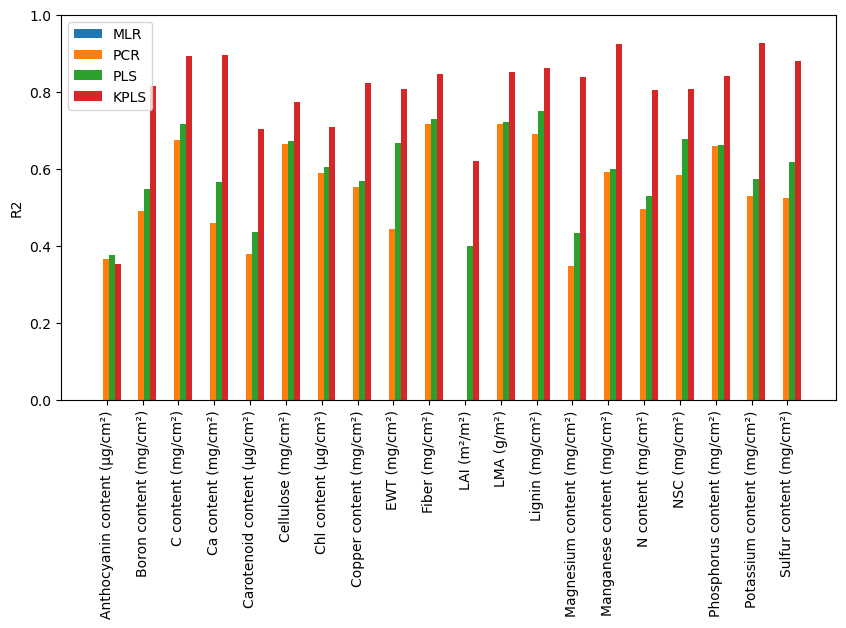

In [88]:
# Plotting the results
x_arr = np.array([[x-0.6, x-0.1, x+0.4, x+0.9] for x in np.arange(0, len(target_cols)*3, 3)])

plt.subplots(figsize=(10, 5))
models = ['MLR', 'PCR', 'PLS', 'KPLS']
for i in range(4):
    plt.bar(x_arr[:, i], np.array(r2_arr)[:,i], width = 0.5, label = models[i])

plt.xticks(np.arange(0, len(target_cols)*3, 3), target_cols, rotation=90)
plt.ylim(0, 1)
plt.legend()
plt.ylabel("R2")
plt.show()

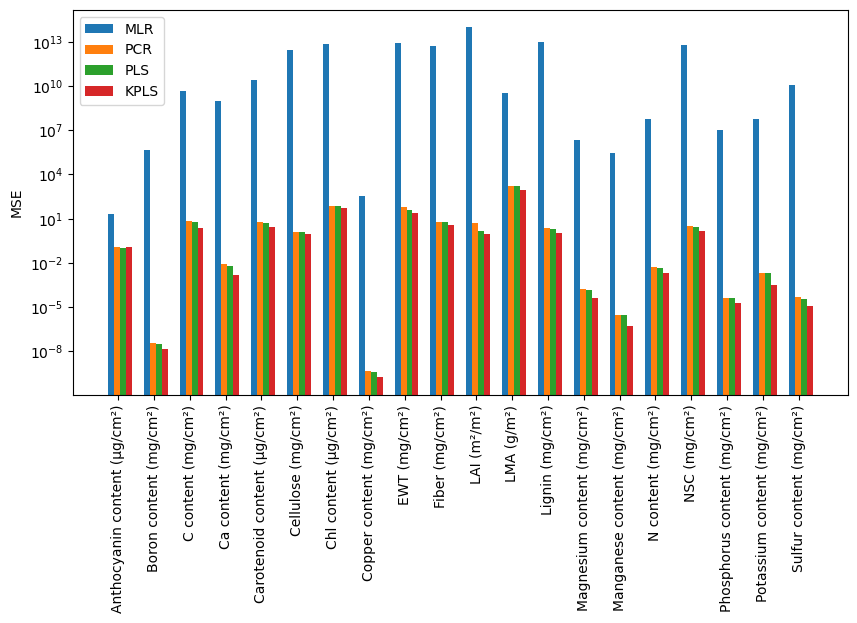

In [89]:
plt.subplots(figsize=(10, 5))
for i in range(4):
    plt.bar(x_arr[:, i], np.array(mse_arr)[:,i], width = 0.5, label = models[i])

plt.xticks(np.arange(0, len(target_cols)*3, 3), target_cols, rotation=90)
plt.legend()
plt.ylabel("MSE")
plt.yscale('log')
plt.show()

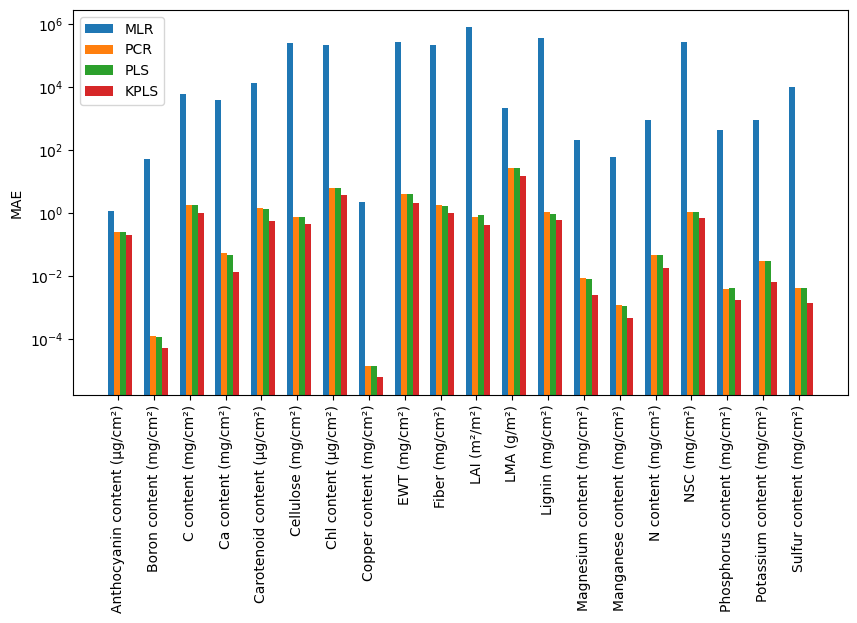

In [91]:
plt.subplots(figsize=(10, 5))
for i in range(4):
    plt.bar(x_arr[:, i], np.array(mae_arr)[:,i], width = 0.5, label = models[i])

plt.xticks(np.arange(0, len(target_cols)*3, 3), target_cols, rotation=90)
plt.legend()
plt.ylabel("MAE")
plt.yscale('log')
plt.show()

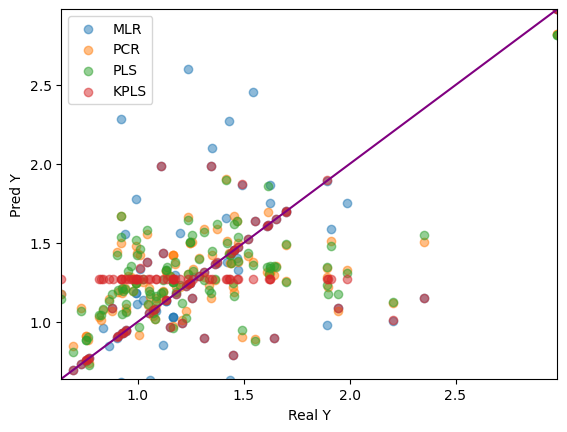

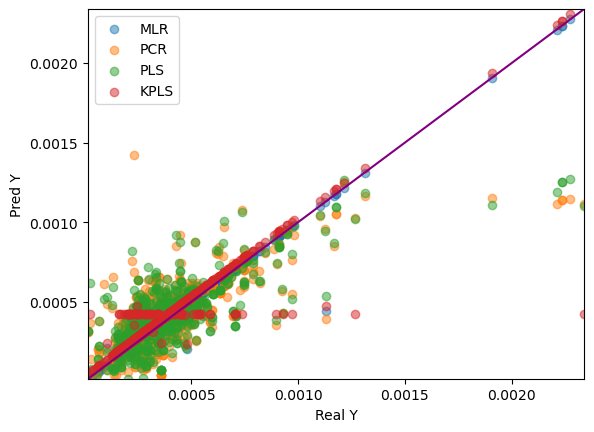

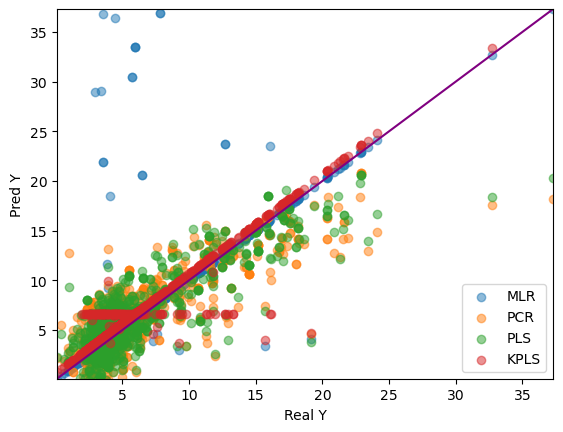

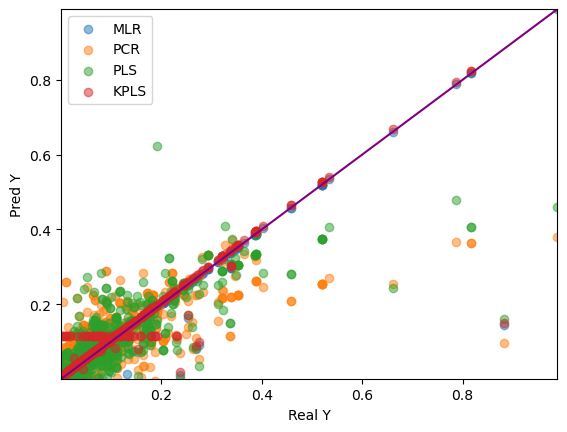

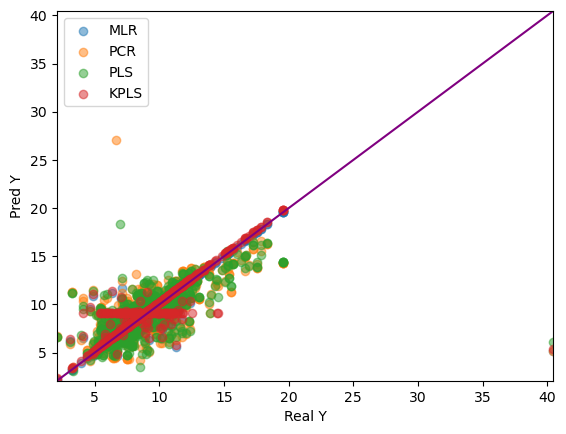

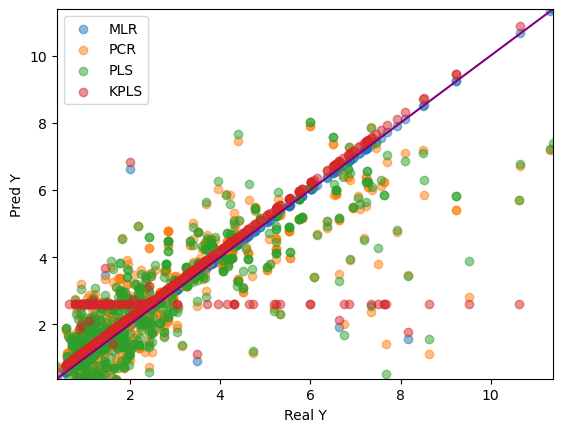

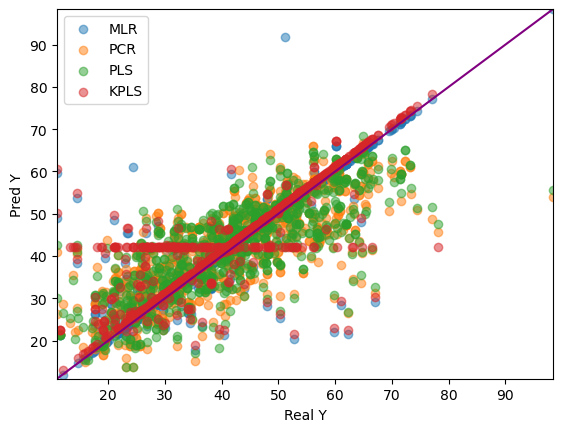

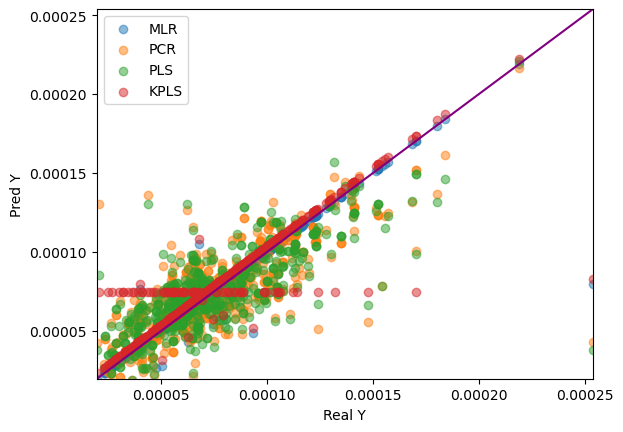

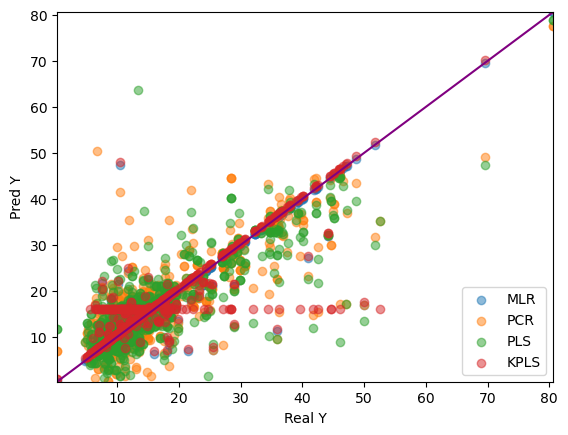

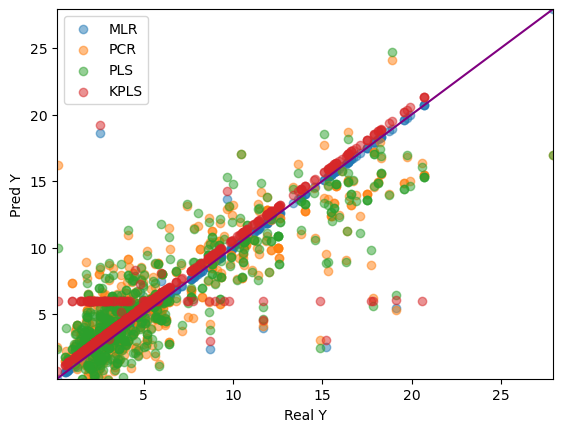

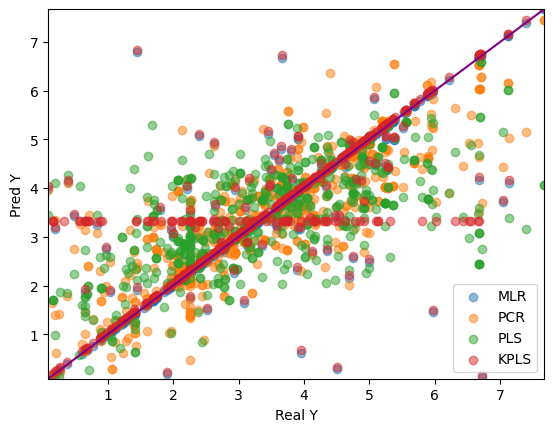

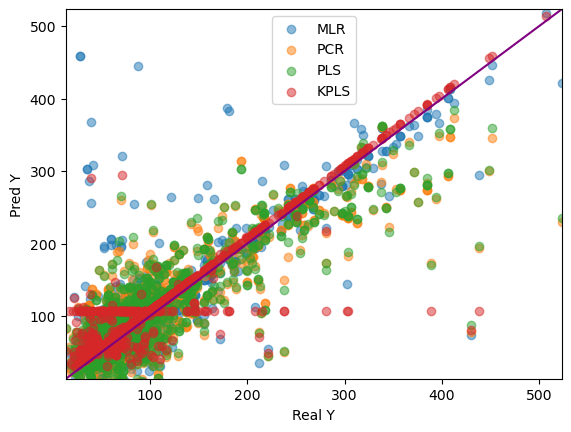

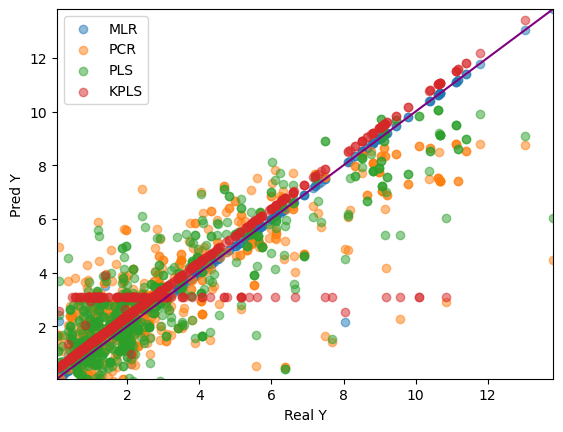

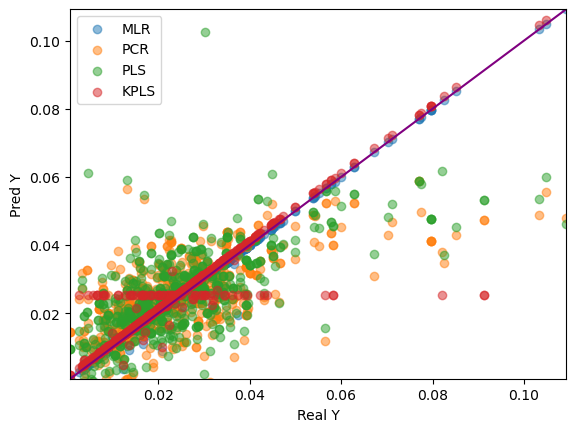

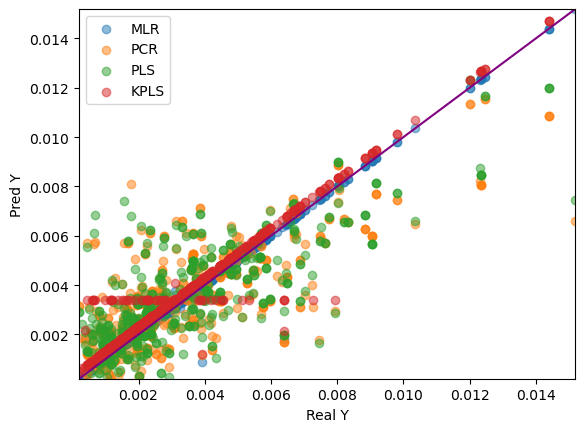

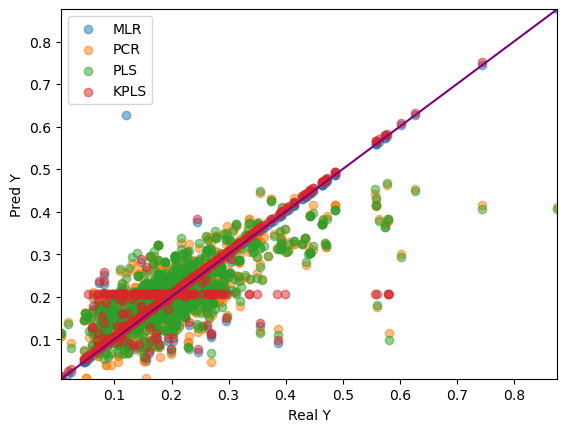

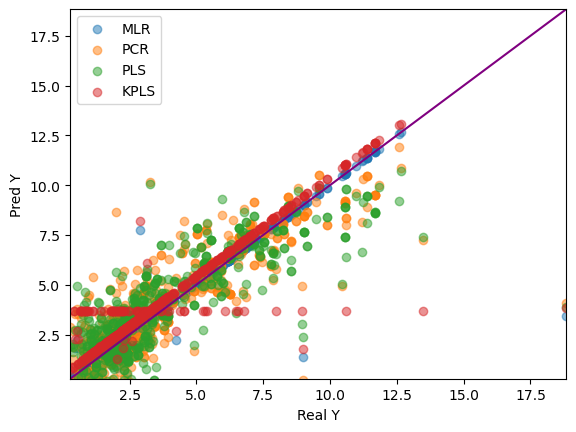

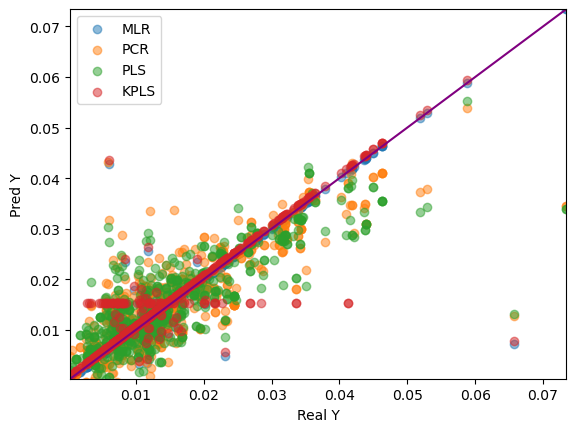

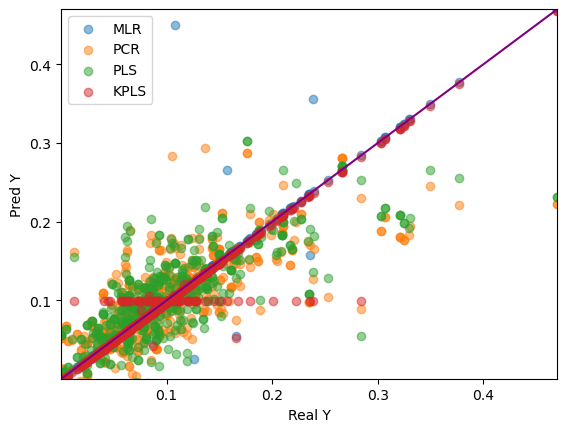

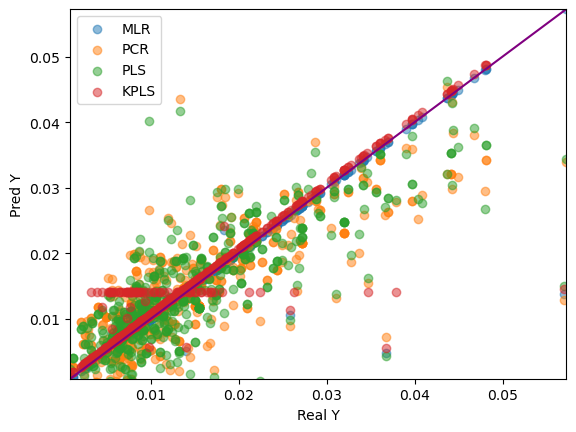

In [98]:
# Comparing the point clouds

for trait in range(len(target_cols)):
    plt.scatter(test_yl[trait], predictions_MLR[trait], label='MLR', alpha=0.5)
    plt.scatter(test_yl[trait], predictions_PCR[trait], label='PCR', alpha=0.5)
    plt.scatter(test_yl[trait], predictions_PLS[trait], label='PLS', alpha=0.5)
    plt.scatter(test_yl[trait], predictions_KPLS[trait], label='KPLS', alpha=0.5)
    
    plt.plot([test_yl[trait].min(), test_yl[trait].max()], [test_yl[trait].min(), test_yl[trait].max()], c='Purple')
    plt.ylim(test_yl[trait].min(), test_yl[trait].max())
    plt.xlim(test_yl[trait].min(), test_yl[trait].max())
    plt.legend()
    plt.xlabel("Real Y")
    plt.ylabel("Pred Y")
    plt.show()